In [2]:
import pandas as pd
import os
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
def get_trial_seg(experiment_triggers, xz_position_data):
    trial_data = []

    rewards_trigger = [31,32,33,34,35,36]
    cue_onset_triggers = [11,12,13,14,15,16]
    cue_offset_triggers = [21,22,23,24,25,26]
    error_timeout_triggers = [41,42,43,44,45,46]


    # Initialize tracking variables
    prev_reward = None
    cue_offset = None
    cue_offset_i = None

    for i, trigger in enumerate(experiment_triggers):
        if trigger == 0: 
            continue
        
        if trigger in rewards_trigger:
            prev_reward = trigger
            continue

        if trigger in cue_onset_triggers:

            continue

        if trigger in cue_offset_triggers:
            cue_offset = trigger
            cue_offset_i = i

            # Find the next reward after the cue offset
            reward_found = False

            for j in range(cue_offset_i, len(experiment_triggers)):
                if experiment_triggers[j] in error_timeout_triggers:
                    # Reset variables if an error/timeout occurs before finding a reward
                    cue_offset = None
                    cue_offset_i = None
                    reward_found = False
                    break  # Stop searching in this trial

                if experiment_triggers[j] in rewards_trigger:
                    reward_i = j
                    reward_found = True
                    break

            if reward_found:
                # Extract position data from cue offset to reward
                x_positions = xz_position_data[0][cue_offset_i:reward_i+1]
                z_positions = xz_position_data[1][cue_offset_i:reward_i+1]

                # Store trial data
                trial_data.append({
                    "prev_reward": prev_reward,
                    "cue_offset": cue_offset,
                    "reward": experiment_triggers[reward_i],
                    "x_positions": x_positions,
                    "z_positions": z_positions
                })

            # Reset tracking variables after completing a segment
            cue_offset = None
            cue_offset_i = None
            
    return pd.DataFrame(trial_data)

def plot_separated_trajectories(trial_df):
    """
    Plots separate figures for each prev_reward with 5 subplots per figure, each showing trajectories
    for a different cue offset (excluding the cue offset that matches prev_reward last digit).

    Parameters:
    trial_df (pd.DataFrame): DataFrame containing trial data.

    Returns:
    None (Displays multiple figures)
    """
    unique_rewards = sorted(trial_df["prev_reward"].unique())  # Unique starting rewards
    cue_offset_triggers = [21, 22, 23, 24, 25, 26]  # Cue offsets
    
    for prev_reward in unique_rewards:
        fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=True, sharey=True)
        fig.suptitle(f"Trajectories for Startingg Position {int(prev_reward)%10}", fontsize=16)
        
        valid_cue_offsets = [c for c in cue_offset_triggers if c % 10 != prev_reward % 10]  # Exclude same digit offsets

        for ax, cue_offset in zip(axes, valid_cue_offsets):
            # Draw maze outer boundary
            maze_boundary = patches.Rectangle((-11, -11), 22, 22, linewidth=2, edgecolor='black', facecolor='none')
            ax.add_patch(maze_boundary)

            # Define goal positions (x, y, width, height, color)
            goal_areas = [
                (-7.5, -7.5, 5, 5, 'blue'),
                (-7.5, 2.5, 5, 5, 'yellow'),
                (2.5, -7.5, 5, 5, 'green'),
                (2.5, 2.5, 5, 5, 'red'),
            ]

            # Draw goal areas
            for x, y, w, h, color in goal_areas:
                ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none'))

            # Filter trials for this prev_reward and cue_offset
            filtered_trials = trial_df[(trial_df["prev_reward"] == prev_reward) & (trial_df["cue_offset"] == cue_offset)]

            if filtered_trials.empty:
                ax.set_title(f"Reward Poster {cue_offset%10} (No Data)")
                continue

            # Plot each trial
            for _, trial in filtered_trials.iterrows():
                x_positions = trial["x_positions"]
                z_positions = trial["z_positions"]

                ax.plot(x_positions, z_positions, linestyle="-", alpha=0.6, markersize=3, label=f"Trial {trial.name}")
                
                # Mark Start (Cue Offset) - Green Square
                ax.scatter(x_positions[0], z_positions[0], color="green", marker="s", s=30, label="Start (Cue Offset)" if _ == 0 else "")
                
                # Mark End (Reward) - Red Cross
                ax.scatter(x_positions[-1], z_positions[-1], color="red", marker="x", s=30, label="End (Reward)" if _ == 0 else "")

            # Labels and Titles
            ax.set_title(f"Reward Poster {cue_offset%10}")
            ax.grid(True)
            ax.set_xlim(-11, 11)
            ax.set_ylim(-11, 11)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
        plt.show()

def plot_maze_with_trajectories(trial_df, prev_reward, cue_offset):
    """
    Plots the predefined maze layout with trial trajectories based on the specified prev_reward and cue_offset.

    Parameters:
    trial_df (pd.DataFrame): DataFrame containing trial data.
    prev_reward (int): Previous reward trigger to filter.
    cue_offset (int): Cue offset trigger to filter.

    Returns:
    None (Displays plot)
    """
    # Define the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw maze outer boundary
    maze_boundary = patches.Rectangle((-11, -11), 22, 22, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(maze_boundary)

    # Define goal positions (x, y, width, height, color)
    goal_areas = [
        (-7.5, -7.5, 5, 5, 'blue'),
        (-7.5, 2.5, 5, 5, 'yellow'),
        (2.5, -7.5, 5, 5, 'green'),
        (2.5, 2.5, 5, 5, 'red'),
    ]

    # Draw goal areas
    for x, y, w, h, color in goal_areas:
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none'))

    # Filter trials based on prev_reward and cue_offset
    filtered_trials = trial_df[(trial_df["prev_reward"] == prev_reward) & (trial_df["cue_offset"] == cue_offset)]
    
    if filtered_trials.empty:
        print(f"No trials found for Prev Reward: {prev_reward} and Cue Offset: {cue_offset}")
        return

    # Plot each trial's trajectory
    for _, trial in filtered_trials.iterrows():
        x_positions = trial["x_positions"]
        z_positions = trial["z_positions"]
        
        ax.plot(x_positions, z_positions, linestyle="-", alpha=0.6, markersize=3, label=f"Trial {trial.name}")  # Smaller circles
        
        # Mark Start (Cue Offset) - Green Square
        ax.scatter(x_positions[0], z_positions[0], color="green", marker="s", s=30, label="Start (Cue Offset)" if _ == 0 else "")
        
        # Mark End (Reward) - Red Cross
        ax.scatter(x_positions[-1], z_positions[-1], color="red", marker="x", s=30, label="End (Reward)" if _ == 0 else "")

    # Labels and Title
    ax.set_xlabel("X Position")
    ax.set_ylabel("Z Position")
    ax.set_title(f"Trajectories (Starting Poster {prev_reward%10} → Goal Poster {cue_offset%10})")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    
    plt.show()

def plot_all_reward_trajectories(trial_df):
    """
    Plots trajectories in separate subplots based on previous reward.
    
    Parameters:
    trial_df (pd.DataFrame): DataFrame containing trial data.

    Returns:
    None (Displays plot)
    """
    unique_rewards = sorted(trial_df["prev_reward"].unique())  # Get unique starting rewards

    # Define figure with subplots (arrange in grid)
    num_rewards = len(unique_rewards)
    cols = 3  # Define number of columns in the subplot grid
    rows = -(-num_rewards // cols)  # Calculate required rows (ceiling division)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes for easy indexing

    # Loop through each unique previous reward
    for idx, prev_reward in enumerate(unique_rewards):
        ax = axes[idx]

        # Draw maze outer boundary
        maze_boundary = patches.Rectangle((-11, -11), 22, 22, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(maze_boundary)

        # Define goal positions (x, y, width, height, color)
        goal_areas = [
            (-7.5, -7.5, 5, 5, 'blue'),
            (-7.5, 2.5, 5, 5, 'yellow'),
            (2.5, -7.5, 5, 5, 'green'),
            (2.5, 2.5, 5, 5, 'red'),
        ]

        # Draw goal areas
        for x, y, w, h, color in goal_areas:
            ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none'))

        # Filter trials for this prev_reward
        filtered_trials = trial_df[trial_df["prev_reward"] == prev_reward]

        if filtered_trials.empty:
            ax.set_title(f"No trials found for Prev Reward {prev_reward%10}")
            continue

        # Loop through each trial
        for _, trial in filtered_trials.iterrows():
            cue_offset = trial["cue_offset"]
            
            # Skip trials where the starting reward maps to the same cue offset (e.g., 31 → 21)
            if prev_reward % 10 == cue_offset % 10:
                continue
            
            x_positions = trial["x_positions"]
            z_positions = trial["z_positions"]

            ax.plot(x_positions, z_positions, linestyle="-", alpha=0.6, markersize=3, label=f"Trial {trial.name}")  # Smaller circles
            
            # Mark Start (Cue Offset) - Green Square
            ax.scatter(x_positions[0], z_positions[0], color="green", marker="s", s=30, label="Start (Cue Offset)" if _ == 0 else "")
            
            # Mark End (Reward) - Red Cross
            ax.scatter(x_positions[-1], z_positions[-1], color="red", marker="x", s=30, label="End (Reward)" if _ == 0 else "")

        # Labels and Titles
        ax.set_xlabel("X Position")
        ax.set_ylabel("Z Position")
        ax.set_title(f"Trajectories (Start {prev_reward%10})")
        ax.grid(True)
        ax.set_xlim(-11, 11)
        ax.set_ylim(-11, 11)

    # Hide any extra empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [4]:
day = "20181105"
unity_file = h5py.File(f"/Volumes/Hippocampus/Data/picasso-misc/{day}/session01/unityfile.mat", 'r')

experiment_triggers = unity_file['uf']['data']['unityData'][0]
xz_position_data = [unity_file['uf']['data']['unityData'][2],unity_file['uf']['data']['unityData'][3]]

trial_df = get_trial_seg(experiment_triggers, xz_position_data)



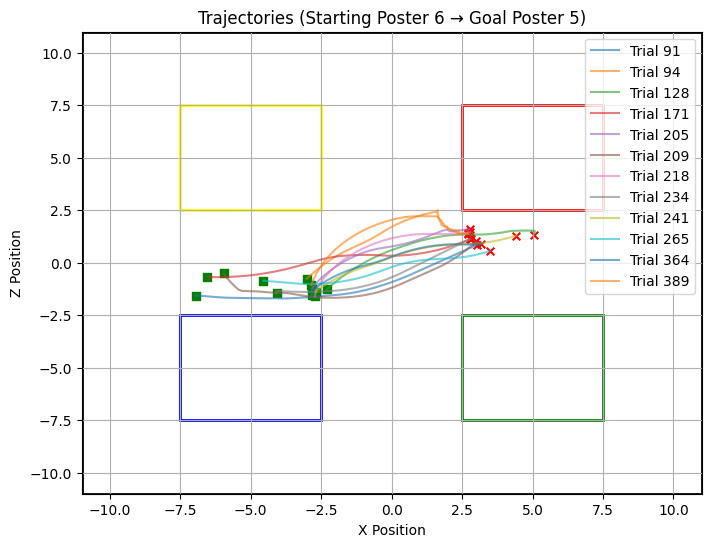

In [28]:
plot_maze_with_trajectories(trial_df, prev_reward=36, cue_offset=25)

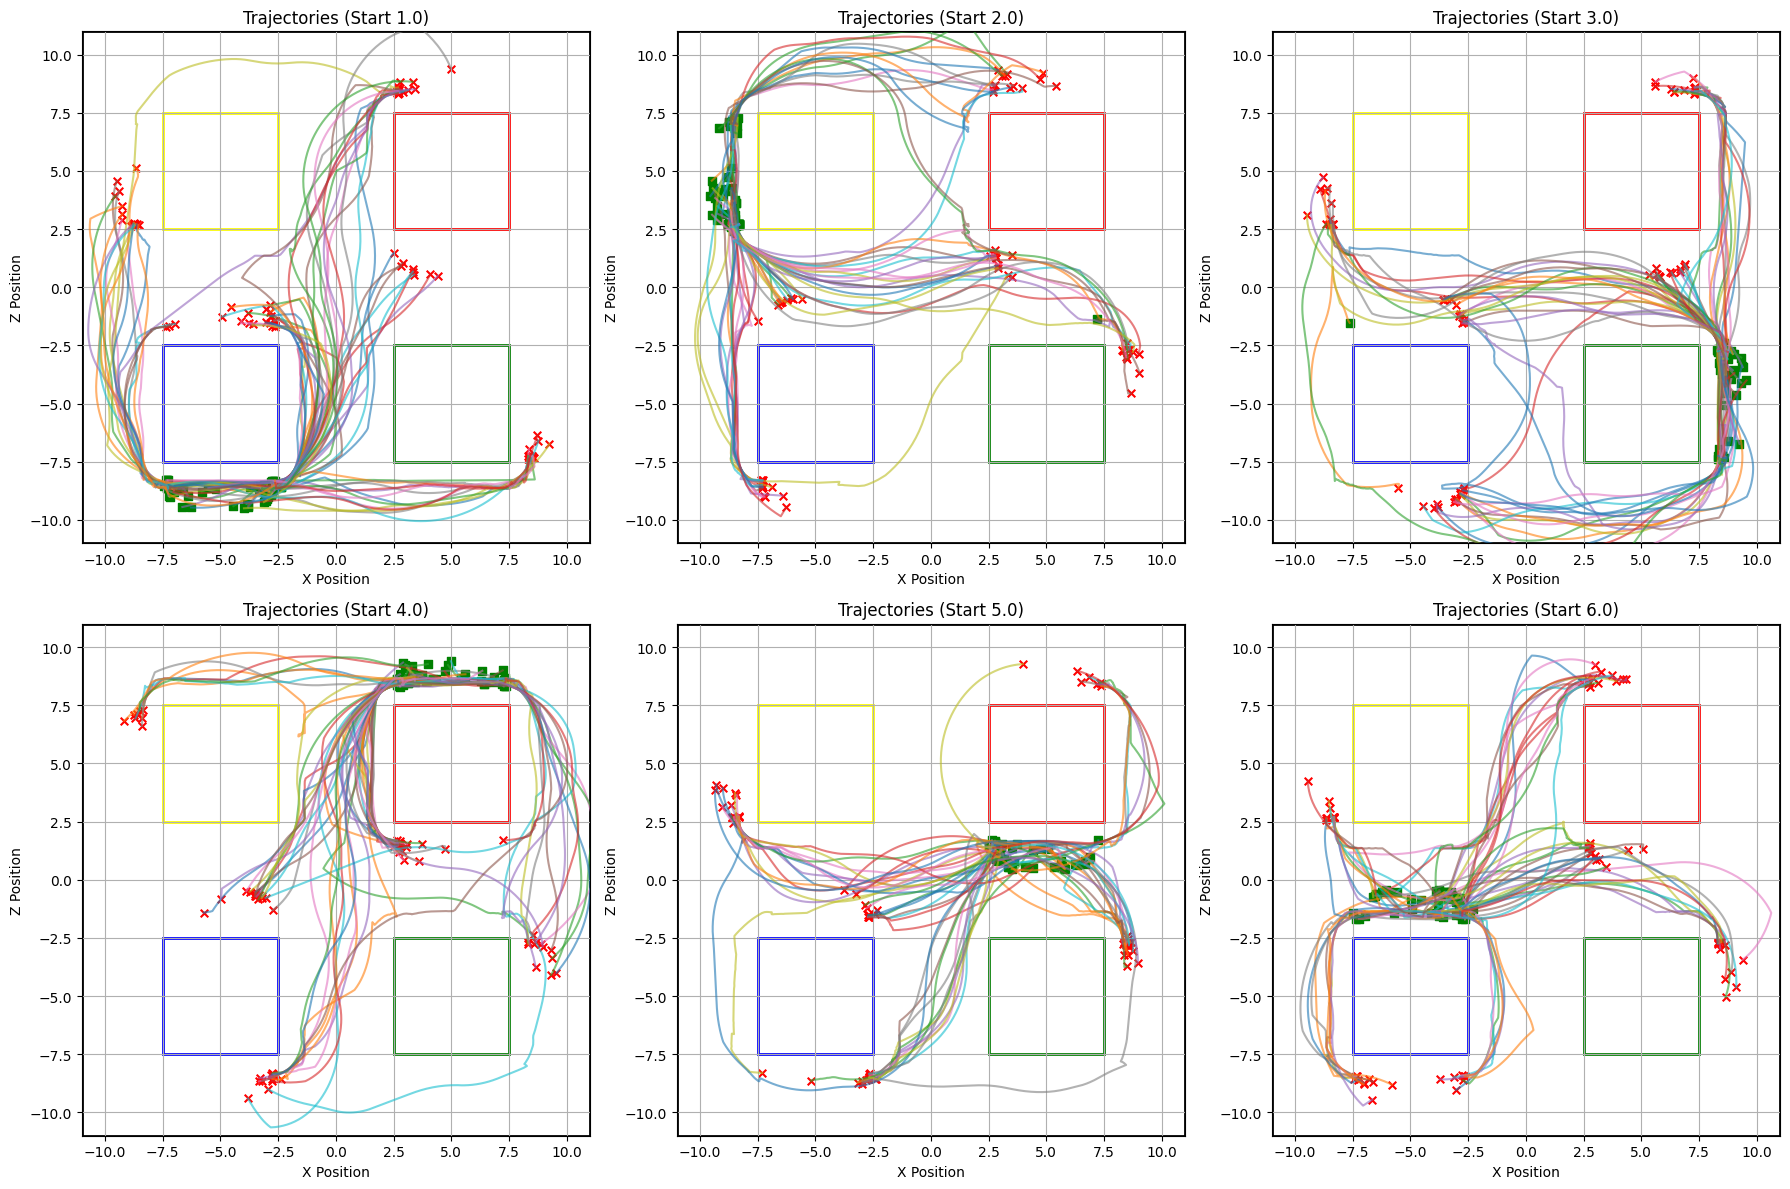

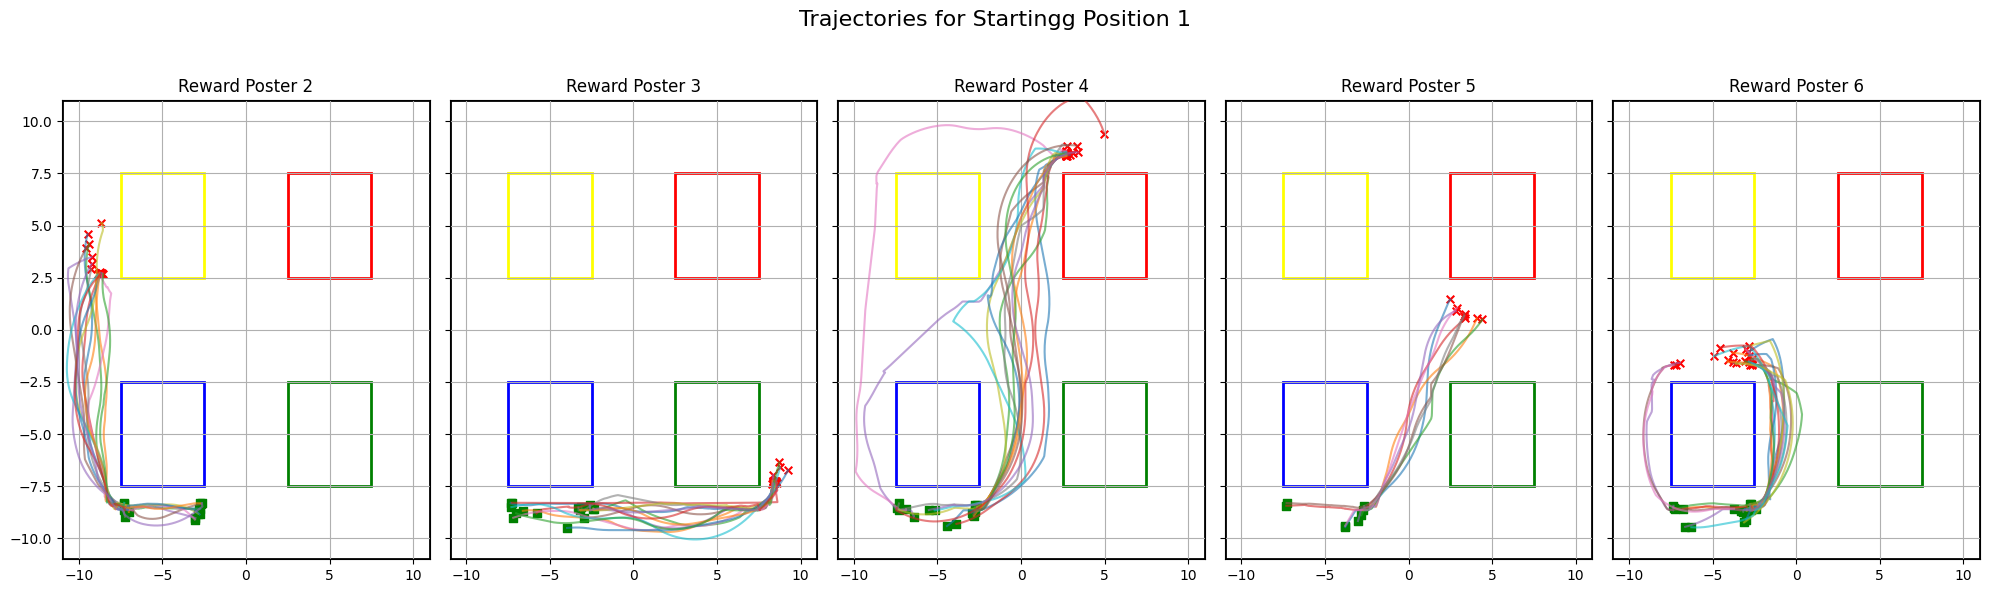

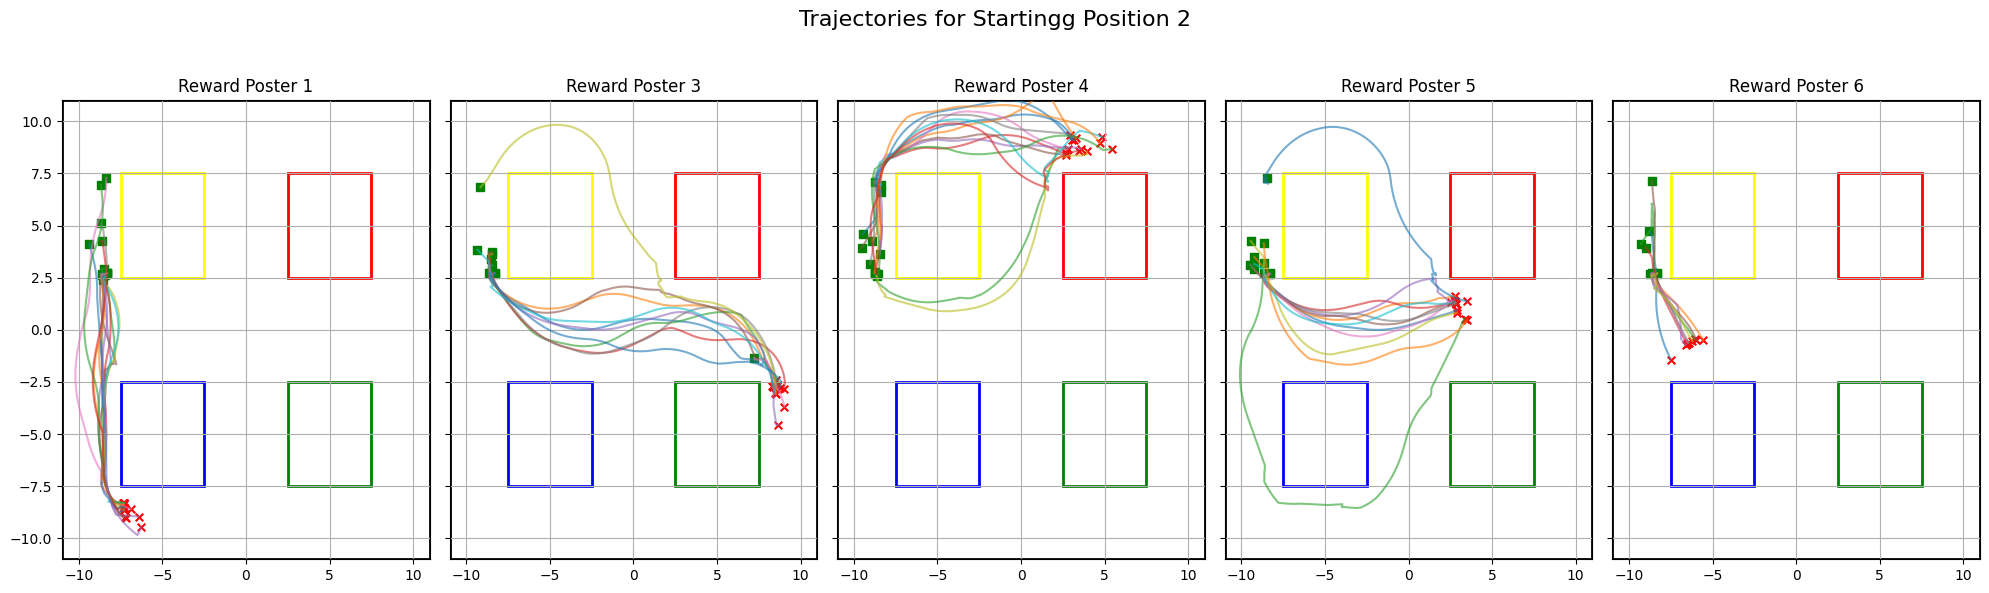

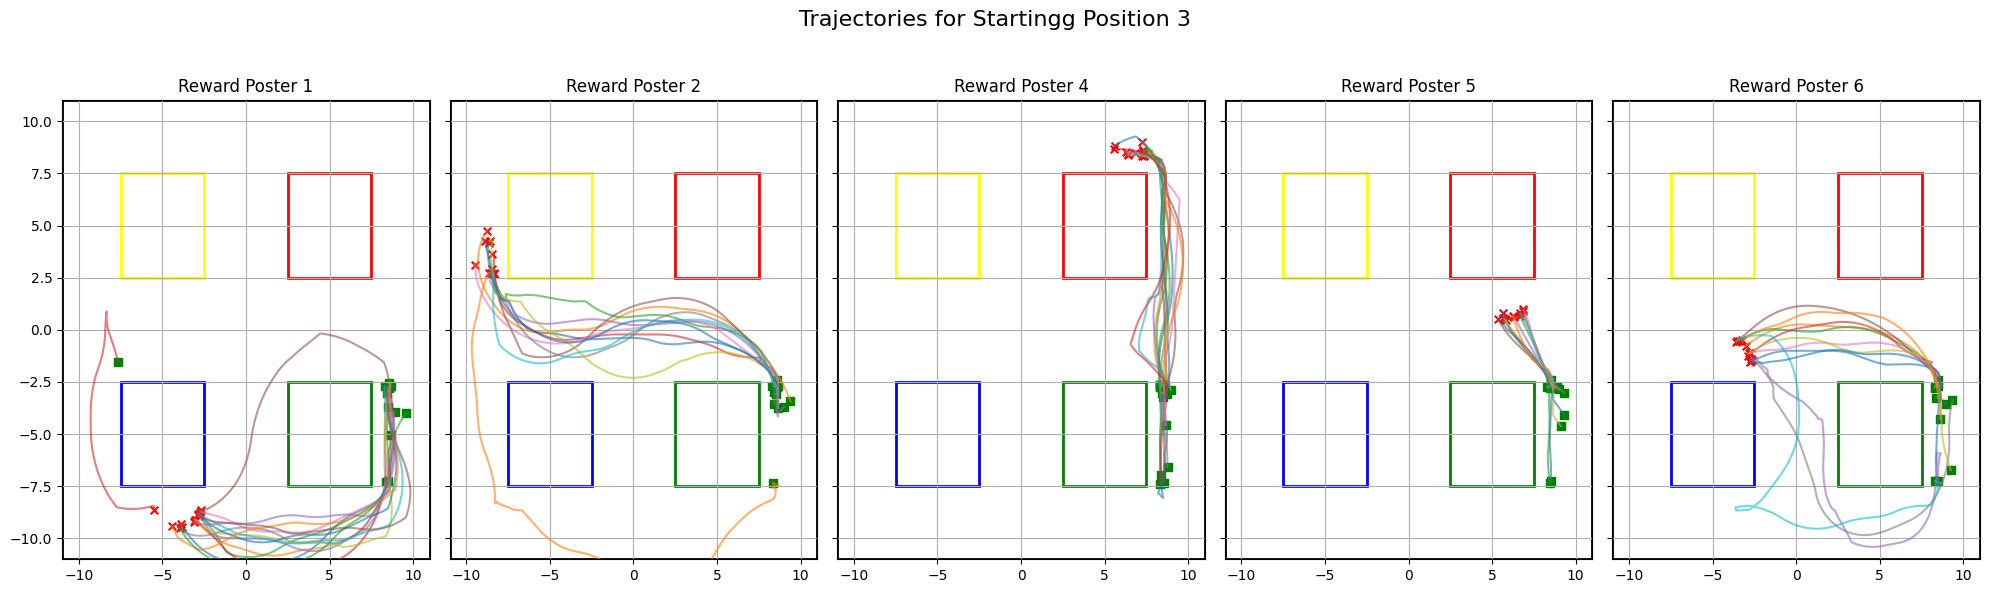

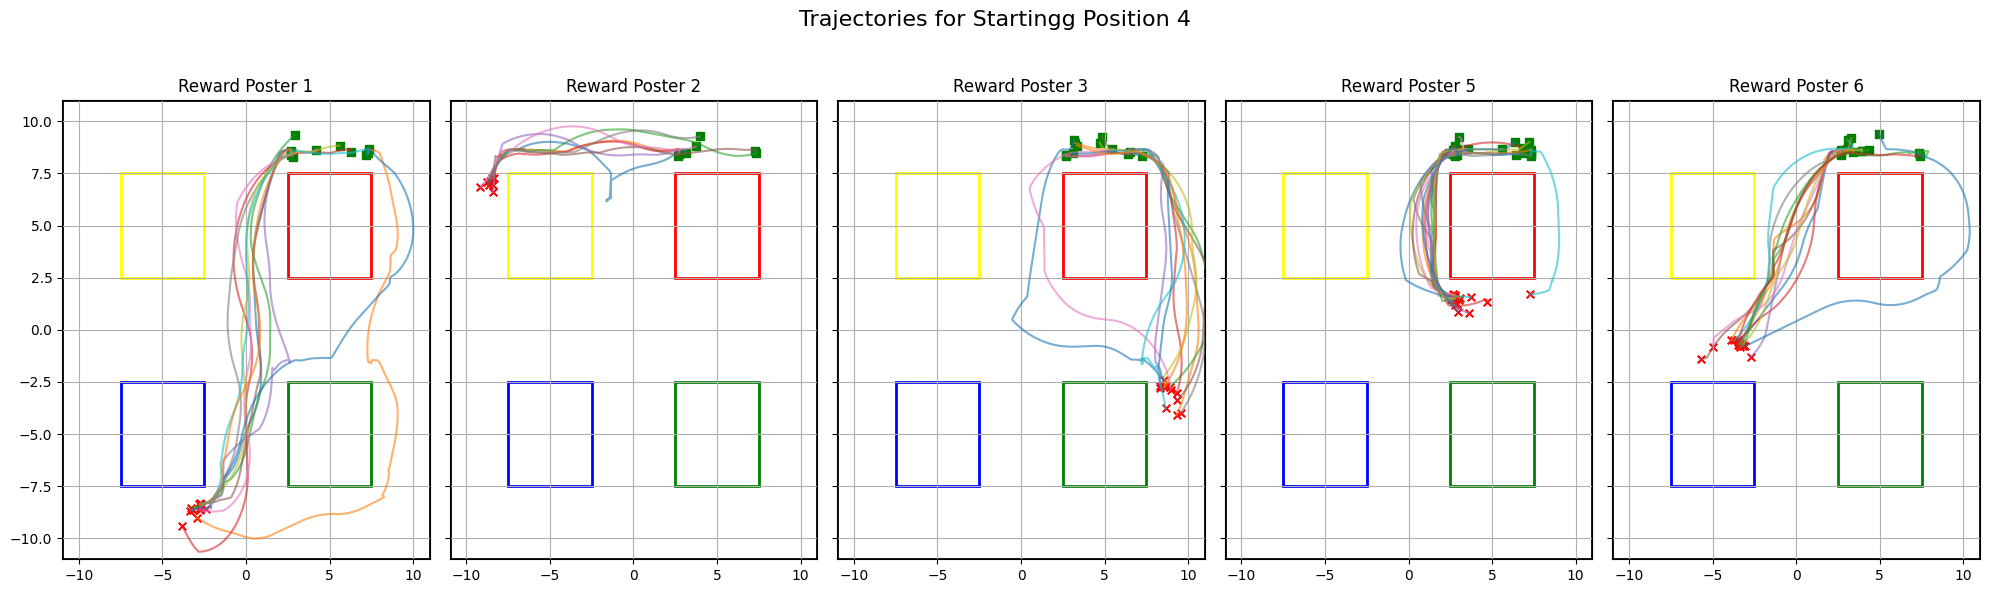

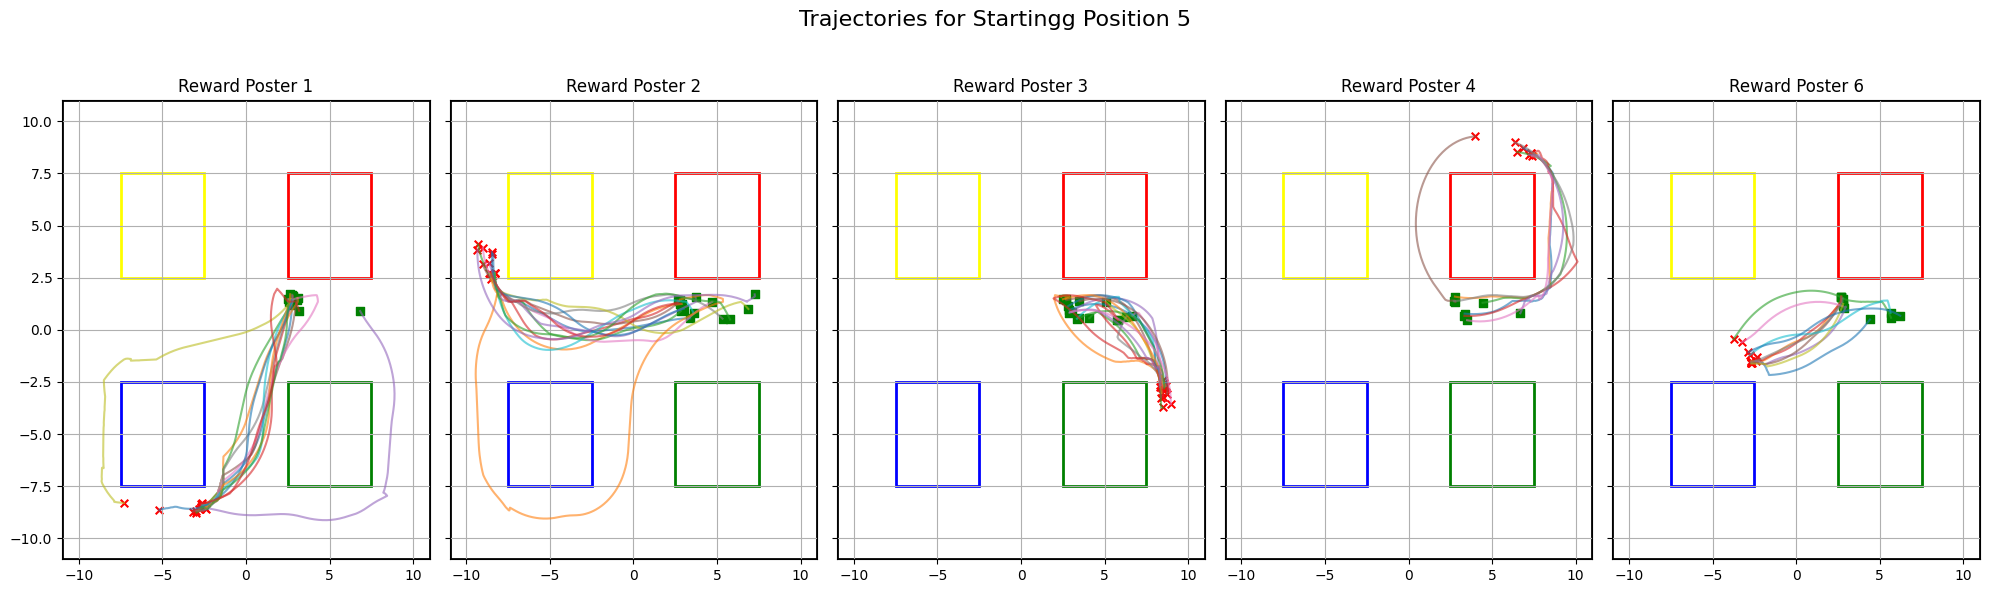

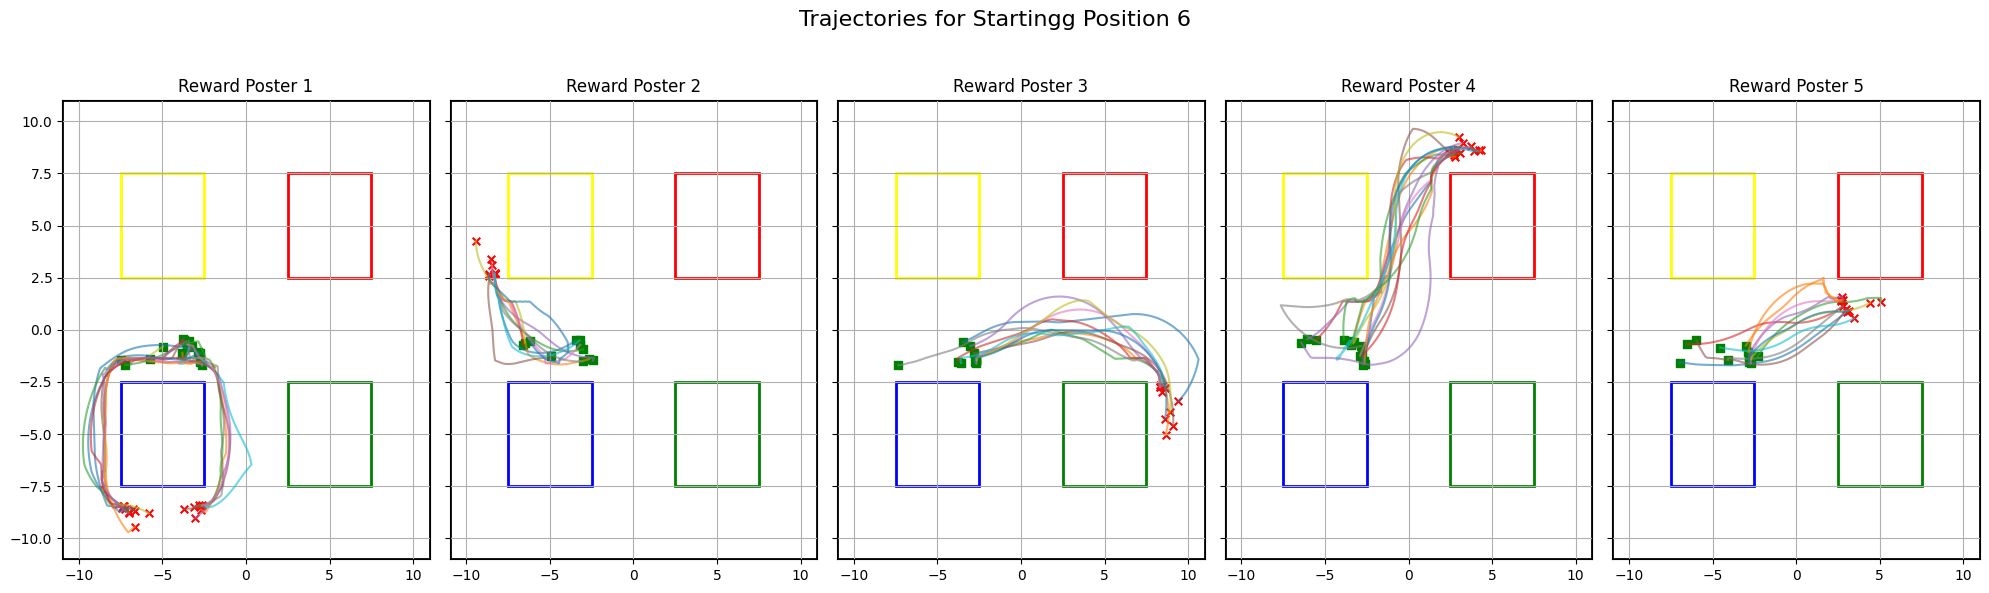

In [27]:
plot_all_reward_trajectories(trial_df[1:])
plot_separated_trajectories(trial_df[1:])
